### About Dataset
Source [Kaggle A/B test Cookie-cats](https://www.kaggle.com/datasets/zahrazolghadr/ab-test-cookie-cats/data)

<img src="https://storage.googleapis.com/kaggle-datasets-images/4191171/7237222/1a4bc67a13f8544e8764b41925550455/dataset-cover.png?t=2023-12-19-12-27-02g" alt="Cookie-cats" width="400"/>


##### This dataset comprises A/B test outcomes for Cookie Cats, investigating the impact of relocating the initial gate in the game from level 30 to level 40. Upon installing the game, players were randomly assigned to either gate_30 or gate_40.
##### The data we have is from 90189 players that installed the game while the AB-test was running.  The variables are: 
- userid: A unique number that identifies each player
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40)
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

### AB-test checks two hypotheses:
1. HO: There is not sufficient difference between values in the 'sum_gamerounds' column for levels 30 and 40
2. H1: There is sufficient difference between values in the 'sum_gamerounds' column for levels 30 and 40

The study encompasses the following steps:
1. Analysis of Cookie Cats dataset
2. Clean up the Dataframe
3. Check that the sample size is sufficient for the A/B test
4. Check if the 'sum_gamerounds' column is a normal distribution
5. Check the hypothesis that test group 'gate_40' is different from control group 'gate_30' by using the Mann-Whitney U statistic
6. Check the hypothesis that test group 'gate_40' is different from control group 'gate_30' by using the z-test
7. Check metrics


### 1. Analysis of Cookie Cats dataset

In [45]:
# Import the Dataset

import pandas as pd
df = pd.read_csv("\cookie_cats.txt")

In [46]:
# Import necessary libraries for plotting

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest


In [47]:
a = df.shape
print(f'Size of dataframe: {a}')

Size of dataframe: (90189, 5)


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


##### Conclusion: The data frame doesn't have null values

In [49]:
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [50]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

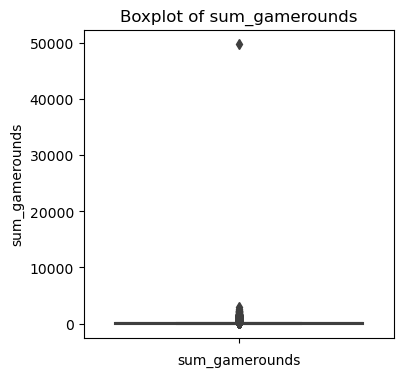

In [51]:
# Create a boxplot to visualize the data distribution
plt.figure(figsize=(4, 4))
sns.boxplot(y=df['sum_gamerounds'])
plt.title('Boxplot of sum_gamerounds')
plt.xlabel('sum_gamerounds')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


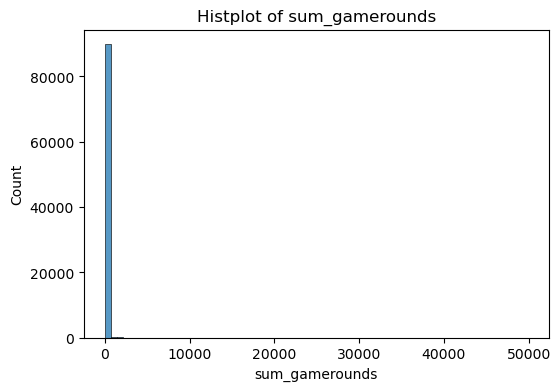

In [52]:
# Create a histplot to visualize the data distribution
plt.figure(figsize=(6, 4))
sns.histplot(x=df['sum_gamerounds'], bins = 70)
plt.title('Histplot of sum_gamerounds')
plt.xlabel('sum_gamerounds')
plt.show()

##### Conclusion: The data distribution is not normal and contains significant outliers

#### Check metrics

In [53]:
# Calculate total sum_gamerounds and count of users per version
df_agg_data = df.groupby('version').agg(
    total_sum_gamerounds=('sum_gamerounds', 'sum'),
    users=('userid', 'count'),
    retention_1_users=('retention_1', 'mean'),
    retention_7_users=('retention_7', 'mean')
).reset_index()

# Create DataFrame
df_agg = pd.DataFrame(df_agg_data)

# Calculate relative changes
relative_changes = df_agg.iloc[1].copy()
relative_changes[1:] = ((df_agg.iloc[1, 1:].values - df_agg.iloc[0, 1:].values) / df_agg.iloc[0, 1:].values) * 100
relative_changes['version'] = 'relative_change_%'

# Create the table with relational changes.

result_row = pd.concat([df_agg, pd.DataFrame([relative_changes], columns=df_agg.columns)], ignore_index=True)

# Transposing the DataFrame
result_transposed_row = result_row.set_index('version').transpose()

print(result_transposed_row)


version                    gate_30       gate_40  relative_change_%
total_sum_gamerounds  2.344795e+06  2.333530e+06          -0.480426
users                 4.470000e+04  4.548900e+04           1.765101
retention_1_users     4.481879e-01  4.422827e-01          -1.317566
retention_7_users     1.902013e-01  1.820000e-01          -4.311903


##### Conclusion: The metrics for level 40 are worse than those for level 30

### 2. Clean up the Dataframe

In [54]:
# Use the upper level of sum_gamerounds, which is 3 standard deviations

# Calculate the standard deviation
std_dev = np.std(df['sum_gamerounds'], ddof=0)  # ddof=0 for population standard deviation
print(f"Population standard deviation is: {std_dev:.2f}")

# Calculate the mean of the dataset
mean_all = df['sum_gamerounds'].mean()
print(f"The mean of sum_gamerounds is: {mean_all:.2f}")

# Calculate the upper level of sum_gamerounds
upper_level = mean_all + 3*std_dev
print(f"The upper level of sum_gamerounds is: {upper_level:.2f}")

Population standard deviation is: 195.05
The mean of sum_gamerounds is: 51.87
The upper level of sum_gamerounds is: 637.02


In [55]:
# Clear the dataset from outliers of more than 3 standard deviations in the 'sum_gamerounds' column 

df_filter = df[df['sum_gamerounds'] < upper_level]

In [56]:
# Check result of clearing
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89764 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          89764 non-null  int64 
 1   version         89764 non-null  object
 2   sum_gamerounds  89764 non-null  int64 
 3   retention_1     89764 non-null  bool  
 4   retention_7     89764 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.9+ MB


In [57]:
df_filter['sum_gamerounds'].describe()

count    89764.000000
mean        47.216824
std         80.655584
min          0.000000
25%          5.000000
50%         16.000000
75%         50.000000
max        637.000000
Name: sum_gamerounds, dtype: float64

### 3. Check that the sample size is sufficient for the A/B test

In [58]:

import statsmodels.stats.api as sms

# Separate the data into two groups
group_gate_30 = df_filter[df_filter['version'] == 'gate_30']['sum_gamerounds']
group_gate_40 = df_filter[df_filter['version'] == 'gate_40']['sum_gamerounds']

# Calculate means and standard deviations
mean_gate_30 = group_gate_30.mean()
mean_gate_40 = group_gate_40.mean()
std_gate_30 = group_gate_30.std()
std_gate_40 = group_gate_40.std()

# Effect size calculation: 3% of the mean of the control group
effect_size = 0.03 * mean_gate_30

# Perform power analysis to determine the required sample size
alpha = 0.05  # Significance level
power = 0.80  # Power

# Calculate the pooled standard deviation
pooled_std = ((std_gate_30 ** 2 + std_gate_40 ** 2) / 2) ** 0.5

# Calculate the effect size in terms of Cohen's d
effect_size_cohen = effect_size / pooled_std

# Calculate the required sample size per group
#sample_size = sms.tt_ind_solve_power(effect_size=effect_size_cohen, alpha=alpha, power=power, alternative='larger')
sample_size = sms.tt_ind_solve_power(effect_size=effect_size_cohen, alpha=alpha, power=power, alternative='larger')

print(f'Required sample size per group: {sample_size:.0f}')

# Check if we have enough data
n_gate_30 = len(group_gate_30)
n_gate_40 = len(group_gate_40)

print(f'Actual sample size for gate_30: {n_gate_30}')
print(f'Actual sample size for gate_40: {n_gate_40}')

if n_gate_30 >= sample_size and n_gate_40 >= sample_size:
    print('The sample size is sufficient for the A/B test.')
else:
    print('The sample size is not sufficient for the A/B test.')


Required sample size per group: 39642
Actual sample size for gate_30: 44500
Actual sample size for gate_40: 45264
The sample size is sufficient for the A/B test.


#### Analysis of Dataframes df_gate_30 and df_gate_40

In [59]:
# Analysis of the Dataframe df_gate_30
df_gate_30 = df_filter[df_filter['version']== 'gate_30']
df_gate_30['sum_gamerounds'].describe()

count    44500.000000
mean        47.486494
std         81.340691
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max        637.000000
Name: sum_gamerounds, dtype: float64

In [60]:
# Analysis of Dataframes df_gate_40
df_gate_40 = df_filter[df_filter['version']== 'gate_40']
df_gate_40['sum_gamerounds'].describe()

count    45264.000000
mean        46.951706
std         79.976331
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max        637.000000
Name: sum_gamerounds, dtype: float64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


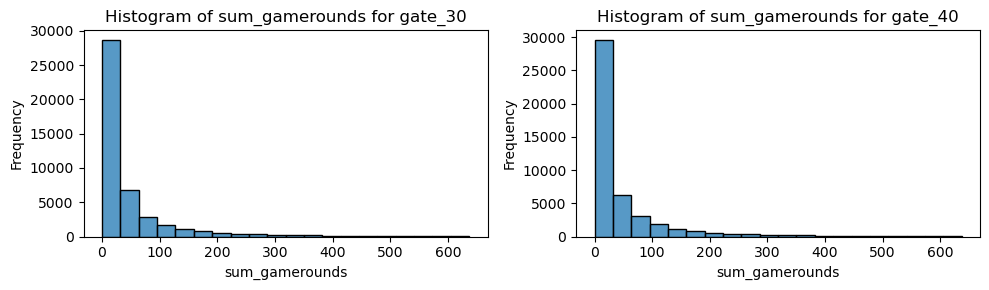

In [61]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot the histogram for df_gate_30
sns.histplot(df_gate_30['sum_gamerounds'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of sum_gamerounds for gate_30')
axes[0].set_xlabel('sum_gamerounds')
axes[0].set_ylabel('Frequency')

# Plot the histogram for df_gate_40
sns.histplot(df_gate_40['sum_gamerounds'], bins=20, ax=axes[1])
axes[1].set_title('Histogram of sum_gamerounds for gate_40')
axes[1].set_xlabel('sum_gamerounds')
axes[1].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


##### Conclusion: the distributions of 'sum_gamerounds' for gate_30 and for gate_40 are the same

### 4. Check if the 'sum_gamerounds' column is a normal distribution

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


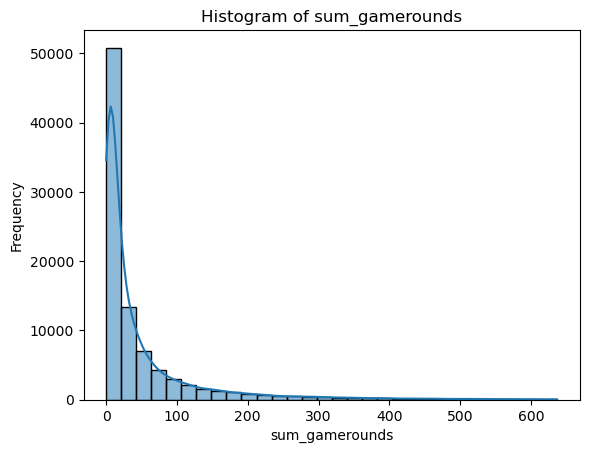

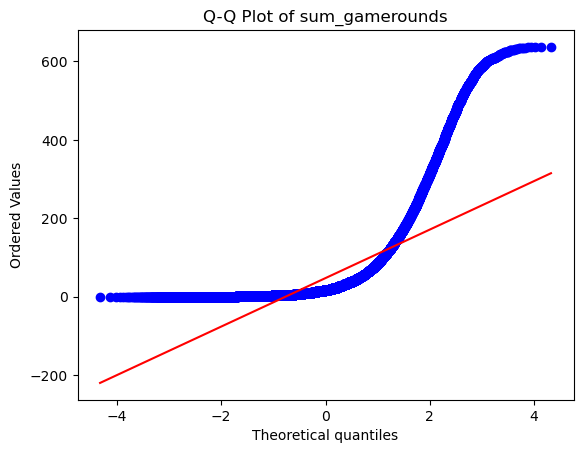

Shapiro-Wilk test statistic: 0.5889525413513184
Shapiro-Wilk p-value: 0.0
Kolmogorov-Smirnov test statistic: 0.2791350374589336
Kolmogorov-Smirnov p-value: 0.0
Anderson-Darling test statistic: 11771.469582558115
Critical values:
 15.0: 0.576
 10.0: 0.656
 5.0: 0.787
 2.5: 0.918
 1.0: 1.092


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [62]:
import scipy.stats as stats
from scipy.stats import shapiro, kstest, anderson

# Plot Histogram
sns.histplot(df_filter['sum_gamerounds'], bins=30, kde=True)
plt.title('Histogram of sum_gamerounds')
plt.xlabel('sum_gamerounds')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
stats.probplot(df_filter['sum_gamerounds'], dist="norm", plot=plt)
plt.title('Q-Q Plot of sum_gamerounds')
plt.show()

# Perform Shapiro-Wilk test
shapiro_stat, shapiro_p_value = shapiro(df_filter['sum_gamerounds'])
print(f"Shapiro-Wilk test statistic: {shapiro_stat}")
print(f"Shapiro-Wilk p-value: {shapiro_p_value}")

# Perform Kolmogorov-Smirnov test
ks_stat, ks_p_value = kstest(df_filter['sum_gamerounds'], 'norm', args=(df_filter['sum_gamerounds'].mean(), df_filter['sum_gamerounds'].std()))
print(f"Kolmogorov-Smirnov test statistic: {ks_stat}")
print(f"Kolmogorov-Smirnov p-value: {ks_p_value}")

# Perform Anderson-Darling test
ad_result = anderson(df_filter['sum_gamerounds'], dist='norm')
print(f"Anderson-Darling test statistic: {ad_result.statistic}")
print("Critical values:")
for i, crit in enumerate(ad_result.critical_values):
    print(f" {ad_result.significance_level[i]}: {crit}")


##### Conclusion: all three tests (Shapiro-Wilk, Kolmogorov-Smirnov, and Anderson-Darling) provide strong evidence that the dataset df_filter['sum_gamerounds'] does not follow a normal distribution. The test statistics are significantly different from what would be expected under normality, and the p-values are all very low, reinforcing the rejection of the null hypothesis of normality.

### 5. Check the hypothesis that test group 'gate_40' is different from control group 'gate_30' by using the Mann-Whitney U statistic

In [63]:
# Use the Mann-Whitney U statistic
# Separate the data into two groups
group_gate_30 = df_filter[df_filter['version'] == 'gate_30']['sum_gamerounds']
group_gate_40 = df_filter[df_filter['version'] == 'gate_40']['sum_gamerounds']

# Perform the Mann-Whitney U test, one-side
u_statistic, p_value = stats.mannwhitneyu(group_gate_30, group_gate_40, alternative='less')

print(f'Mann-Whitney U statistic: {u_statistic}')
print(f'p-value: {p_value}')

# Determine if the result is significant at the 0.05 significance level
if p_value < 0.05:
    print('The difference between the two groups is statistically significant.')
else:
    print('The difference between the two groups is not statistically significant.')


Mann-Whitney U statistic: 1015257071.5
p-value: 0.9819619083172588
The difference between the two groups is not statistically significant.


### 6. Check the hypothesis that test group 'gate_40' is different from control group 'gate_30' by using the z-test

In [64]:
# Use the z-test and check the metrics

from scipy import stats

# Calculate total sum_gamerounds and count of users per version
agg_data = df_filter.groupby('version').agg(
    total_sum_gamerounds=('sum_gamerounds', 'sum'),
    users=('userid', 'count'),
    retention_1_users=('retention_1', 'mean'),
    retention_7_users=('retention_7', 'mean')
).reset_index()

# Calculate means
mean_gate_30 = agg_data.loc[agg_data['version'] == 'gate_30', 'total_sum_gamerounds'].values[0] / agg_data.loc[agg_data['version'] == 'gate_30', 'users'].values[0]
mean_gate_40 = agg_data.loc[agg_data['version'] == 'gate_40', 'total_sum_gamerounds'].values[0] / agg_data.loc[agg_data['version'] == 'gate_40', 'users'].values[0]

print(f"Mean total_sum_gamerounds for gate_30: {mean_gate_30}")
print(f"Mean total_sum_gamerounds for gate_40: {mean_gate_40}")

# Perform One-Sided T-Test
sum_gamerounds_gate_30 = df_filter[df_filter['version'] == 'gate_30']['sum_gamerounds']
sum_gamerounds_gate_40 = df_filter[df_filter['version'] == 'gate_40']['sum_gamerounds']

# Assume variances are unequal (Welch's t-test)
t_stat, p_value = stats.ttest_ind(sum_gamerounds_gate_40, sum_gamerounds_gate_30, alternative='greater', equal_var=False)

# Calculate the expected mean difference for 3% increase
mean_diff_expected = 0.03 * mean_gate_30

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check Controlled Metrics
# Retention 1
retention_1_gate_30 = df_filter[df_filter['version'] == 'gate_30']['retention_1']
retention_1_gate_40 = df_filter[df_filter['version'] == 'gate_40']['retention_1']

# Retention 7
retention_7_gate_30 = df_filter[df_filter['version'] == 'gate_30']['retention_7']
retention_7_gate_40 = df_filter[df_filter['version'] == 'gate_40']['retention_7']

# Proportion test for retention metrics
count_retention_1 = np.array([retention_1_gate_30.sum(), retention_1_gate_40.sum()])
nobs_retention_1 = np.array([retention_1_gate_30.count(), retention_1_gate_40.count()])
stat_retention_1, pval_retention_1 = proportions_ztest(count_retention_1, nobs_retention_1)

count_retention_7 = np.array([retention_7_gate_30.sum(), retention_7_gate_40.sum()])
nobs_retention_7 = np.array([retention_7_gate_30.count(), retention_7_gate_40.count()])
stat_retention_7, pval_retention_7 = proportions_ztest(count_retention_7, nobs_retention_7)

print(f"Retention 1 p-value: {pval_retention_1}")
print(f"Retention 7 p-value: {pval_retention_7}")

# Interpret Results
if p_value < 0.05 and mean_gate_40 > mean_gate_30 * 1.03:
    print("The total_sum_gamerounds for gate_40 is significantly greater than gate_30 by at least 3%.")
else:
    print("The total_sum_gamerounds for gate_40 is not significantly greater than gate_30 by at least 3%.")

if pval_retention_1 >= 0.05 and pval_retention_7 >= 0.05:
    print("Retention metrics did not significantly worsen.")
else:
    print("Retention metrics significantly worsened.")


Mean total_sum_gamerounds for gate_30: 47.48649438202247
Mean total_sum_gamerounds for gate_40: 46.95170554966419
T-statistic: -0.9930948046188114
P-value: 0.839666782149814
Retention 1 p-value: 0.05785348312893759
Retention 7 p-value: 0.0007179701949517202
The total_sum_gamerounds for gate_40 is not significantly greater than gate_30 by at least 3%.
Retention metrics significantly worsened.


### 7. Check metrics

In [65]:

# Create DataFrame
df_all = pd.DataFrame(agg_data)

# Calculate relative changes
relative_changes = df_all.iloc[1].copy()
relative_changes[1:] = ((df_all.iloc[1, 1:].values - df_all.iloc[0, 1:].values) / df_all.iloc[0, 1:].values) * 100
relative_changes['version'] = 'relative_change_%'

# Create the table with relational changes.
result = pd.concat([df_all, pd.DataFrame([relative_changes], columns=df_all.columns)], ignore_index=True)

# Transposing the DataFrame
result_transposed = result.set_index('version').transpose()

print(result_transposed)

version                    gate_30       gate_40  relative_change_%
total_sum_gamerounds  2.113149e+06  2.125222e+06           0.571327
users                 4.450000e+04  4.526400e+04           1.716854
retention_1_users     4.459326e-01  4.396430e-01          -1.410438
retention_7_users     1.867640e-01  1.780444e-01          -4.668823


#### Conclusion: Retention metrics significantly worsened.